In [19]:
import pandas as pd
import numpy as np
import time
import os

try:
    # Load the uploaded files
    data_range = pd.read_csv('../data/data_range.csv')
    sample_dataset = pd.read_csv('../data/sample_dataset.csv')
except FileNotFoundError as e:
    print("Error: One or more input files are missing. Please ensure both 'data_range.csv' and 'sample_dataset.csv' exist.")
    print(f"Details: {e}")
    raise
except Exception as e:
    print("Error: An unexpected issue occurred while loading the files.")
    print(f"Details: {e}")
    raise

# Extract criteria, min, and max values
criteria = data_range['Criteria']
min_values = data_range['Min']
max_values = data_range['Max']

# Number of records to generate
num_records = 1_000_000

# Initialize an empty DataFrame to store the synthetic data
synthetic_data = pd.DataFrame()

print("Starting data generation process...")

# Generate synthetic data based on the ranges
for index, criterion in enumerate(criteria):
    print(f"Generating data for {criterion}...")
    synthetic_data[criterion] = np.random.uniform(
        low=min_values[index], 
        high=max_values[index], 
        size=num_records
    )

print("Data generation completed.")

# Save the synthetic data as a CSV file for verification
synthetic_data_path = '../data/synthetic_data.csv'
try:
    print(f"Saving data to {synthetic_data_path}...")
    if os.path.exists(synthetic_data_path):
        print(f"Warning: File '{synthetic_data_path}' already exists and will be overwritten.")
    synthetic_data.to_csv(synthetic_data_path, index=False)
    
    # Add a waiting time to ensure the file is saved properly
    time.sleep(5)
    print(f"File saved successfully at {synthetic_data_path}.")
except PermissionError as e:
    print("Error: Permission denied. The file might be open or locked by another process.")
    print(f"Details: {e}")
except IOError as e:
    print("Error: An I/O error occurred while saving the file.")
    print(f"Details: {e}")
except Exception as e:
    print("Error: An unexpected issue occurred while saving the file.")
    print(f"Details: {e}")


Starting data generation process...
Generating data for Annual Revenue...
Generating data for Gross Profit...
Generating data for Credit Score...
Generating data for Debt-to-Income Ratio...
Generating data for Outstanding Loan Amount...
Generating data for Loan-to-Value Ratio...
Generating data for Missed Payments...
Generating data for Liquidity Ratio...
Generating data for Profitability Ratio...
Generating data for Operating Cash Flow...
Generating data for Employee Count...
Generating data for Inventory Turnover...
Generating data for Operational Expense...
Generating data for Market Share...
Generating data for Sales Growth...
Generating data for Customer Churn Rate...
Generating data for Supplier Reliability...
Generating data for Regulatory Compliance Score...
Generating data for R&D Spending...
Generating data for Delivery Time...
Generating data for Interest Rate...
Generating data for Stock Market Index...
Generating data for GDP Growth Rate...
Generating data for Inflation Ra

Starting data generation process...
Generating data for Annual Revenue...
Generating data for Gross Profit...
Generating data for Credit Score...
Generating data for Debt-to-Income Ratio...
Generating data for Outstanding Loan Amount...
Generating data for Loan-to-Value Ratio...
Generating data for Missed Payments...
Generating data for Liquidity Ratio...
Generating data for Profitability Ratio...
Generating data for Operating Cash Flow...
Generating data for Employee Count...
Generating data for Inventory Turnover...
Generating data for Operational Expense...
Generating data for Market Share...
Generating data for Sales Growth...
Generating data for Customer Churn Rate...
Generating data for Supplier Reliability...
Generating data for Regulatory Compliance Score...
Generating data for R&D Spending...
Generating data for Delivery Time...
Generating data for Interest Rate...
Generating data for Stock Market Index...
Generating data for GDP Growth Rate...
Generating data for Inflation Ra

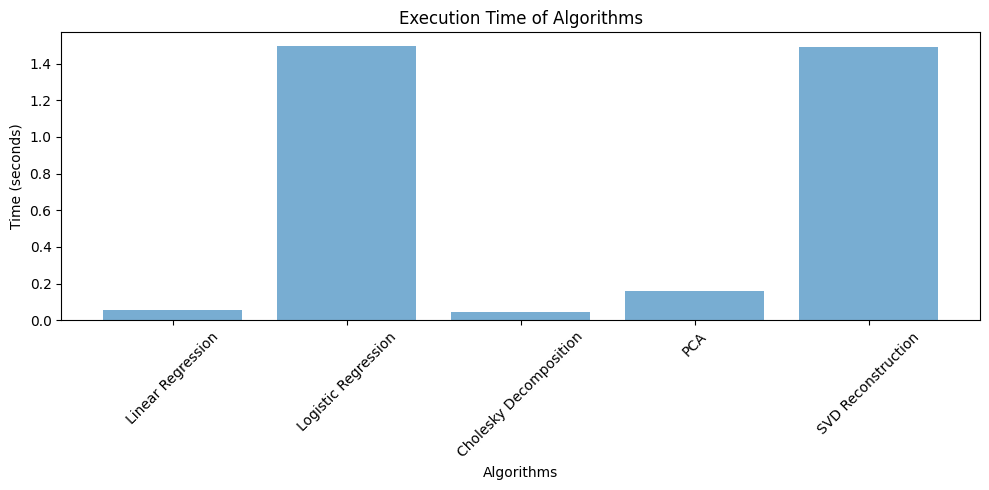

In [3]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.linear_model import LogisticRegression
from scipy.linalg import cholesky, solve_triangular
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import psutil

try:
    # Load the uploaded files
    data_range = pd.read_csv('../data/data_range.csv')
    sample_dataset = pd.read_csv('../data/sample_dataset.csv')
except FileNotFoundError as e:
    print("Error: One or more input files are missing. Please ensure both 'data_range.csv' and 'sample_dataset.csv' exist.")
    print(f"Details: {e}")
    raise
except Exception as e:
    print("Error: An unexpected issue occurred while loading the files.")
    print(f"Details: {e}")
    raise

# Extract criteria, min, and max values
criteria = data_range['Criteria']
min_values = data_range['Min']
max_values = data_range['Max']

# Number of records to generate
num_records = 1_000_000

# Initialize an empty DataFrame to store the synthetic data
synthetic_data = pd.DataFrame()

print("Starting data generation process...")

# Generate synthetic data based on the ranges
for index, criterion in enumerate(criteria):
    print(f"Generating data for {criterion}...")
    synthetic_data[criterion] = np.random.uniform(
        low=min_values[index], 
        high=max_values[index], 
        size=num_records
    )

print("Data generation completed.")

# Save the synthetic data as a CSV file for verification
synthetic_data_path = '../data/synthetic_data.csv'
try:
    print(f"Saving data to {synthetic_data_path}...")
    if os.path.exists(synthetic_data_path):
        print(f"Warning: File '{synthetic_data_path}' already exists and will be overwritten.")
    synthetic_data.to_csv(synthetic_data_path, index=False)
    
    # Add a waiting time to ensure the file is saved properly
    time.sleep(5)
    print(f"File saved successfully at {synthetic_data_path}.")
except PermissionError as e:
    print("Error: Permission denied. The file might be open or locked by another process.")
    print(f"Details: {e}")
except IOError as e:
    print("Error: An I/O error occurred while saving the file.")
    print(f"Details: {e}")
except Exception as e:
    print("Error: An unexpected issue occurred while saving the file.")
    print(f"Details: {e}")

# Select numerical features
numerical_data = synthetic_data.select_dtypes(include=[np.number]).to_numpy()
assert numerical_data.shape[0] > 0, "Dataset is empty!"
print(f"Dataset Generated: {numerical_data.shape[0]} rows and {numerical_data.shape[1]} columns.\n")

# Create dummy target variable \(y\) for regression
y_regression = np.random.rand(numerical_data.shape[0], 1)  # Random continuous target
y_classification = np.random.randint(0, 2, size=(numerical_data.shape[0],))  # Binary target

# Split dataset into train and test sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(numerical_data, y_regression, test_size=0.3, random_state=42)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(numerical_data, y_classification, test_size=0.3, random_state=42)

# Step 2: Profiling Function
def profile_function(func, *args):
    """Profile CPU, cache, memory, and execution time during function execution."""
    process = psutil.Process()
    start_time = time.perf_counter()
    mem_before = process.memory_info().rss  # Memory usage in bytes
    cache_before = process.memory_info().pfaults  # Page faults as a proxy for cache
    result = func(*args)
    end_time = time.perf_counter()
    mem_after = process.memory_info().rss
    cache_after = process.memory_info().pfaults
    cpu_time = process.cpu_times().user + process.cpu_times().system

    return {
        "result": result,
        "execution_time": end_time - start_time,
        "memory_usage_change": (mem_after - mem_before) / 1e6,  # Memory in MB
        "cache_usage_change": cache_after - cache_before,  # Cache usage change
        "cpu_time": cpu_time,
    }

# Step 3: Algorithms with Profiling and Verification

# Linear Regression
def linear_regression_multiplications(X, y):
    """Compute Linear Regression beta step-by-step with matrix multiplications."""
    A = X.T @ X  # Multiplication 1
    b = X.T @ y  # Multiplication 2
    beta = np.linalg.inv(A) @ b  # Solve Ax = b
    predictions = X @ beta  # Compute predictions
    return predictions, beta

# Logistic Regression
def logistic_regression(X, y):
    """Fit logistic regression and predict probabilities."""
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    probabilities = model.predict_proba(X)[:, 1]  # Predict probabilities
    return probabilities, model

# Cholesky Decomposition
def cholesky_solver(X, y):
    """Solve Ax = b using Cholesky decomposition."""
    A = X.T @ X
    b = X.T @ y
    L = cholesky(A, lower=True)
    z = solve_triangular(L, b, lower=True)
    x = solve_triangular(L.T, z, lower=False)
    return X @ x  # Compute predictions

# PCA with Manual Multiplications
def manual_pca(X):
    """Compute PCA using matrix multiplications."""
    mean_centered = X - X.mean(axis=0)
    covariance_matrix = mean_centered.T @ mean_centered  # Multiplication 1
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    transformed_data = mean_centered @ eigenvectors[:, :1]  # Reduced dimension
    return transformed_data

# SVD Reconstruction
def svd_reconstruction(X):
    """Reconstruct X using Singular Value Decomposition."""
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S_diag = np.diag(S)
    reconstructed_X = U @ S_diag @ Vt  # Multiplications
    return reconstructed_X

# Step 4: Execute and Profile Each Algorithm
execution_times = {}
verification_results = {}

print("=== Profiling and Verification ===\n")

# Linear Regression
print("1. Starting Linear Regression...")
profile_lr = profile_function(linear_regression_multiplications, X_train, y_train_reg)
execution_times['Linear Regression'] = profile_lr['execution_time']
predictions_train, _ = profile_lr['result']
predictions_test, _ = linear_regression_multiplications(X_test, y_test_reg)
verification_results['Linear Regression'] = {
    "MSE": mean_squared_error(y_test_reg, predictions_test),
    "MAE": mean_absolute_error(y_test_reg, predictions_test),
    "R2": r2_score(y_test_reg, predictions_test)
}
print(f"Linear Regression Done.")
print(f"  Time: {profile_lr['execution_time']:.2f}s, Memory Usage Change: {profile_lr['memory_usage_change']:.2f}MB, CPU Time: {profile_lr['cpu_time']:.2f}s, Cache Usage Change: {profile_lr['cache_usage_change']}\n")

# Logistic Regression
print("2. Starting Logistic Regression...")
profile_logr = profile_function(logistic_regression, X_train_cls, y_train_cls)
execution_times['Logistic Regression'] = profile_logr['execution_time']
logr_probabilities_train, logr_model = profile_logr['result']
logr_predictions_test = logr_model.predict(X_test_cls)
verification_results['Logistic Regression'] = {
    "Accuracy": accuracy_score(y_test_cls, logr_predictions_test),
    "Precision": precision_score(y_test_cls, logr_predictions_test),
    "Recall": recall_score(y_test_cls, logr_predictions_test),
    "F1 Score": f1_score(y_test_cls, logr_predictions_test)
}
print(f"Logistic Regression Done.")
print(f"  Time: {profile_logr['execution_time']:.2f}s, Memory Usage Change: {profile_logr['memory_usage_change']:.2f}MB, CPU Time: {profile_logr['cpu_time']:.2f}s, Cache Usage Change: {profile_logr['cache_usage_change']}\n")

# Cholesky Decomposition
print("3. Starting Cholesky Decomposition...")
profile_cholesky = profile_function(cholesky_solver, X_train, y_train_reg)
execution_times['Cholesky Decomposition'] = profile_cholesky['execution_time']
predictions_test_cholesky = cholesky_solver(X_test, y_test_reg)
verification_results['Cholesky Decomposition'] = {
    "MSE": mean_squared_error(y_test_reg, predictions_test_cholesky),
    "MAE": mean_absolute_error(y_test_reg, predictions_test_cholesky),
    "R2": r2_score(y_test_reg, predictions_test_cholesky)
}
print(f"Cholesky Decomposition Done.")
print(f"  Time: {profile_cholesky['execution_time']:.2f}s, Memory Usage Change: {profile_cholesky['memory_usage_change']:.2f}MB, CPU Time: {profile_cholesky['cpu_time']:.2f}s, Cache Usage Change: {profile_cholesky['cache_usage_change']}\n")

# PCA
print("4. Starting PCA...")
profile_pca = profile_function(manual_pca, X_train)
execution_times['PCA'] = profile_pca['execution_time']
verification_results['PCA'] = {
    "Explained Variance (First Component)": profile_pca['result'].var()
}
print(f"PCA Done.")
print(f"  Time: {profile_pca['execution_time']:.2f}s, Memory Usage Change: {profile_pca['memory_usage_change']:.2f}MB, CPU Time: {profile_pca['cpu_time']:.2f}s, Cache Usage Change: {profile_pca['cache_usage_change']}\n")

# SVD Reconstruction
print("5. Starting SVD Reconstruction...")
profile_svd = profile_function(svd_reconstruction, X_train)
execution_times['SVD Reconstruction'] = profile_svd['execution_time']
verification_results['SVD Reconstruction'] = {
    "MSE": mean_squared_error(X_train, profile_svd['result']),
    "MAE": mean_absolute_error(X_train, profile_svd['result']),
    "R2": r2_score(X_train, profile_svd['result'])
}
print(f"SVD Reconstruction Done.")
print(f"  Time: {profile_svd['execution_time']:.2f}s, Memory Usage Change: {profile_svd['memory_usage_change']:.2f}MB, CPU Time: {profile_svd['cpu_time']:.2f}s, Cache Usage Change: {profile_svd['cache_usage_change']}\n")

# Step 5: Comprehensive Results Report
def print_results_report(results):
    print("\n=== Performance Results ===\n")
    for algo, metrics in results.items():
        print(f"{algo}:")
        for metric, value in metrics.items():
            if value is None:
                print(f"  {metric}: N/A")
            else:
                print(f"  {metric}: {value:.6f}")
        print()

print_results_report(verification_results)

# Step 6: Plot Execution Times
def plot_execution_metrics(times):
    plt.figure(figsize=(10, 5))
    plt.bar(times.keys(), times.values(), color='tab:blue', alpha=0.6)
    plt.xlabel('Algorithms')
    plt.ylabel('Time (seconds)')
    plt.title('Execution Time of Algorithms')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\n=== Generating Plots ===\n")
plot_execution_metrics(execution_times)
